In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import openpyxl
import os


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
figures_dir = TOP + 'reports/figures/'

In [4]:
elsie = pd.read_excel(raw_dir+'ELISE_270919.xlsx', sheet_name = 'ELISE')

In [5]:
elsie.shape

(479, 11)

In [6]:
elsie.head()

,Name,CAS Number,CAS_corrected,INPUT,FOUND_BY,DTXSID,PREFERRED_NAME,CASRN,SMILES,QSAR_READY_SMILES,Unnamed: 10
0,Dibenzylidene Sorbitol,32647-67-9,32647-67-9,32647-67-9,CAS-RN,DTXSID4029355,"D-Glucitol, bis-O-(phenylmethylene)-",32647-67-9,O[C@]12COC(O[C@@H]1[C@H]1OC(OC[C@H]1O2)C1=CC=C...,OC12COC(OC1C1OC(OCC1O2)C1=CC=CC=C1)C1=CC=CC=C1,NaN
1,Caprolactam,105-60-2,105-60-2,105-60-2,CAS-RN,DTXSID4020240,Caprolactam,105-60-2,O=C1CCCCCN1,O=C1CCCCCN1,NaN
2,Benzophenone,119-61-9,119-61-9,119-61-9,CAS-RN,DTXSID0021961,Benzophenone,119-61-9,O=C(C1=CC=CC=C1)C1=CC=CC=C1,O=C(C1=CC=CC=C1)C1=CC=CC=C1,NaN
3,"1,3,5-Trimethyl-2,4,6-tris(3,5-di-tert-butyl-4...",1709-70-2,1709-70-2,1709-70-2,CAS-RN,DTXSID6027428,Ionox 330,1709-70-2,CC1=C(CC2=CC(=C(O)C(=C2)C(C)(C)C)C(C)(C)C)C(C)...,CC1=C(CC2=CC(=C(O)C(=C2)C(C)(C)C)C(C)(C)C)C(C)...,NaN
4,Dibutyl phthalate,84-74-2,84-74-2,84-74-2,CAS-RN,DTXSID2021781,Dibutyl phthalate,84-74-2,CCCCOC(=O)C1=CC=CC=C1C(=O)OCCCC,CCCCOC(=O)C1=CC=CC=C1C(=O)OCCCC,NaN


In [8]:
elsie = elsie[elsie['SMILES'].notnull()]

In [9]:
elsie.shape

(435, 11)

In [11]:
elise_dict ={k:Chem.MolFromSmiles(v) for k,v in zip(elsie['DTXSID'],elsie['SMILES'])}

In [12]:
elise_dict_v1 = {k: v for k, v in elise_dict.items() if v is not None}

In [28]:
elise_dict_smi ={k:v for k,v in zip(elsie['DTXSID'],elsie['SMILES']) if v is not None}

In [13]:
len(elise_dict_v1)

424

In [30]:
#elise_dict_smi

FDA COC listing

In [16]:
fda_coc = pd.read_excel(raw_dir+'FDA_COC.xlsx', sheet_name = 'FDA_COC')

fda_coc = fda_coc.iloc[:, :5]


In [17]:
fda_dict = {}
for i,group in fda_coc.groupby('COC'):
    key = [name for name in group['COC'] if name!=' '][0]
    value = set(group['SMARTS'])
    fda_dict[key]=value

In [18]:
fda_smarts = {k:[Chem.MolFromSmarts(e) for e in v] for k,v in fda_dict.items()}
fda_sms = {k:list(filter(None, fda_smarts[k])) for k,v in fda_smarts.items() }

RDKit ERROR: [09:35:53] SMARTS Parse Error: syntax error while parsing: [$([NX3H2][NX3]([#1,#6;!$([CX3](=[OX1])[#1,#6])_100])[#1,#6;!$([CX3](=[OX1])[#1,#6])_100 show full SMARTS
RDKit ERROR: [09:35:53] SMARTS Parse Error: Failed parsing SMARTS '[$([NX3H2][NX3]([#1,#6;!$([CX3](=[OX1])[#1,#6])_100])[#1,#6;!$([CX3](=[OX1])[#1,#6])_100 show full SMARTS' for input: '[$([NX3H2][NX3]([#1,#6;!$([CX3](=[OX1])[#1,#6])])[#1,#6;!$([CX3](=[OX1])[#1,#6]) show full SMARTS'
RDKit ERROR: [09:35:53] SMARTS Parse Error: syntax error while parsing: [OX2]1[CX4]([#1,c,$([CH3])_100,$([CH2][CH3])_101,$([CH2][CH2][CH3])_102,$([CH]([CH3])[CH3])_103
RDKit ERROR: [09:35:53] SMARTS Parse Error: Failed parsing SMARTS '[OX2]1[CX4]([#1,c,$([CH3])_100,$([CH2][CH3])_101,$([CH2][CH2][CH3])_102,$([CH]([CH3])[CH3])_103' for input: '[OX2]1[CX4]([#1,c,$([CH3]),$([CH2][CH3]),$([CH2][CH2][CH3]),$([CH]([CH3])[CH3])'


In [72]:
#fda_sms

Inorganic filter functions

In [19]:
def has_metal_atom(smiles):
    metal_dict = {'Na': 11 , 'Mg': 12, 'Si': 14, 'K':19, 'Ca':20, 'Mn':25, 'Fe':26, 'Cu':29, 'Zn':30, 'Co':27, 'Ni':28, 'As': 33, 'Cr':24, 'Hg':80, 'Pb':82, 'V':23, 'Al':13, 'Ag':47, 'Cd':48, 'B':5, 'Ti': 22, 'Se': 34, 'Sn': 50, 'Sb':51, 'Be': 4, 'Zr': 40, 'Nb': 41, 'Mo': 42, 'Te':52, 'Ba':56, 'W':74, 'Au': 79, 'Bi': 83}
    essential_metal_dict = {'Na': 11 , 'K':19,'Mg': 12,  'Ca':20, 'Fe':26,  'Mn':25, 'Co':27, 'Cu':29, 'Zn':30, 'Mo': 42}
    mol = Chem.MolFromSmiles(smiles)
    if mol  is None:
        return False
    return any(atom for atom in mol.GetAtoms() if atom.GetAtomicNum() in list(metal_dict.values()))

In [20]:
def metal_ions(smiles):
    essential_metal = ['[Na+]', '[K+]', '[Mg++]',  '[Ca++]', '[Fe+3]',  '[Mn++]', '[Co+]', '[Cu++]', '[Zn++]', '[Mo++]']
    mol = Chem.MolFromSmiles(smiles)
    if mol  is None:
        return False
    return any(mol.HasSubstructMatch(Chem.MolFromSmarts(e)) for e in essential_metal)

In [21]:
def P_inorg(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol  is None:
        return False
    return mol.HasSubstructMatch(Chem.MolFromSmarts('[OH]P(=[O])([OH])[OH]'))

Genotoxicity alerts

In [22]:
genetox = pd.read_excel(raw_dir+'genetox_structural_alerts_201021.xlsx', sheet_name = 'Final')
genetox = genetox.drop_duplicates(['SMARTS'], keep = 'first')

In [23]:
genetox_dict = {}
for i,group in genetox.groupby('ID'):
    key = [name for name in group['ID'] if name!=' '][0]
    value = set(group['SMARTS'])
    genetox_dict[key]=value

In [24]:
genetox_smarts = {k:[Chem.MolFromSmarts(e) for e in v] for k,v in genetox_dict.items()}
genetox_smarts = {k: list(filter(None, genetox_smarts[k])) for k,v in genetox_smarts.items()}

RDKit ERROR: [09:38:46] SMARTS Parse Error: syntax error while parsing: [$([CX4]([$([OH])_100,$(C=O)_101,$([NX3])_102])([!F!Cl!Br!I!C])([*!$(C)_103])[CH2][F,Cl,Br,I])_104,$ show full SMARTS
RDKit ERROR: [09:38:46] SMARTS Parse Error: Failed parsing SMARTS '[$([CX4]([$([OH])_100,$(C=O)_101,$([NX3])_102])([!F!Cl!Br!I!C])([*!$(C)_103])[CH2][F,Cl,Br,I])_104,$ show full SMARTS' for input: '[$([CX4]([$([OH]),$(C=O),$([NX3])])([!F!Cl!Br!I!C])([*!$(C)])[CH2][F,Cl,Br,I]),$ show full SMARTS'
RDKit ERROR: [09:38:46] SMARTS Parse Error: syntax error while parsing: NOT [!CX4!#1!F!Cl!Br!I] AND [CX4!R0][F,Cl,Br,I]
RDKit ERROR: [09:38:46] SMARTS Parse Error: Failed parsing SMARTS 'NOT [!CX4!#1!F!Cl!Br!I] AND [CX4!R0][F,Cl,Br,I]' for input: 'NOT [!CX4!#1!F!Cl!Br!I] AND [CX4!R0][F,Cl,Br,I]'
RDKit ERROR: [09:38:46] SMARTS Parse Error: syntax error while parsing: [a!r0][$([NH2])_100,$([NX3][OX2H1])_101,$([NX3][OX2][CX3H1](=[OX1]))_102,$([NX2]=[CH2])_103,$([N show full SMARTS
RDKit ERROR: [09:38:46] SMARTS

In [46]:
def inorgs(df):
    df['metal_salts'] = [metal_ions(x) for x in df['SMILES']]
    df['inorgs'] = [has_metal_atom(x) for x in df['SMILES']]
    df['inorgP'] = [P_inorg(x) for x in df['SMILES']]
    return df

In [47]:
elsie = inorgs(elsie)

In [48]:
def inorg_filter(df):
    inorg_filter = []
    for x, y, z in list(zip(df['metal_salts'], df['inorgs'], df['inorgP'])):
        if x is True:
            inorg_filter.append('metal_salt')
        elif x is False and y is True:
            inorg_filter.append('inorganic')
        elif z is True:
            inorg_filter.append('inorganic')
        else:
            inorg_filter.append('TTC_NA')
    df['inorg_filter'] = inorg_filter
    return df

In [50]:
elsie = inorg_filter(elsie)

In [85]:
def alert_match(mydict, alert_dict , label = 'COC', label2 = None):
    alert_matches = {x:[k for k, v in alert_dict.items() if any([y.HasSubstructMatch(e) for e in v])] for x,y in mydict.items()}
    alert_matches_df = pd.DataFrame(list(alert_matches.items()), columns = ['DTXSID', label])
    alert_lst = []
    for x in alert_matches_df[label]:
        if x !=[]:
            alert_lst.append(1)
        else:
            alert_lst.append(0)
    alert_matches_df[label2] = alert_lst
    return alert_matches_df

In [78]:
fda_coc_df = coc(elise_dict_v1, fda_sms, label = 'COC')

In [79]:
elsie_coc = pd.merge(elsie, fda_coc_df, on = 'DTXSID', how = 'left')

In [81]:
#elsie_coc

In [87]:
genetox_df = alert_match(elise_dict_v1, genetox_smarts, label = 'Genetox_Alert', label2 = 'Genetox_alert')

In [88]:
elsie_coc_genetox = pd.merge(elsie_coc, genetox_df, on = 'DTXSID', how = 'left')

In [95]:
def final_assignment(df, label = 'final_TTC_category'):
    final_outcome = []
    for a,b,c in list(zip(df['inorg_filter'], df['COC_Alerts'], df['Genetox_alert'] )):
        if a == 'inorganic':
            final_outcome.append('inorganic')
        elif (a != 'inorganic') & (b == 1):
            final_outcome.append('COC')
        elif (a != 'inorganic') & (b == 'None') | (b == 0) & (c == 1):
            final_outcome.append('Genotoxicity Alert')
        elif (a != 'inorganic') & (b == 'None') | (b == 0) & (c == 0):
            final_outcome.append('Cramer_class_applicable')
    df[label] = final_outcome
    return df

In [96]:
final_elsie = final_assignment(elsie_coc_genetox, label ='final_TTC_category' )

In [98]:
final_elsie.final_TTC_category.value_counts(dropna = True)

Cramer_class_applicable    238
Genotoxicity Alert         146
inorganic                   28
COC                         23
Name: final_TTC_category, dtype: int64

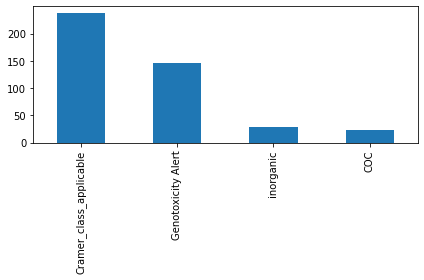

In [100]:
final_elsie.final_TTC_category.value_counts().plot.bar()
plt.tight_layout()
plt.savefig(figures_dir+ 'ELSIE_new_TTC_category_counts_201021.png')

In [101]:
writer = pd.ExcelWriter(interim_dir+ 'ELSIE_201021.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.

final_elsie.to_excel(writer, sheet_name = 'final')



writer.save()